HEALTH_SCORE_

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HT‑cable fault‑forecast + health‑score pipeline (multi‑year, unique SWNOs)
--------------------------------------------------------------------------
* Forecast years: 2018‑2025  (needs ≥2 yrs history before each target)
* Training set for year Y = ALL earlier forecast years (<Y)
* Predicts 12 months per switch even if history is all‑zero.
* Health‑scoring keeps one row per switch (duplicates dropped).
"""

from __future__ import annotations
import logging, numpy as np, pandas as pd
from pathlib import Path
from warnings import filterwarnings
filterwarnings("ignore")

# ───────── DEPENDENCIES ─────────────────────────────────────────────────────
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import *
import matplotlib.pyplot as plt

# ───────── CONFIG (EDIT THESE 3 PATHS ONLY) ────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_with_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

MIN_YEAR, TARGET_YEAR = 2016, 2024
TRAIN_TARGET_YEARS    = list(range(2018, TARGET_YEAR))   # 2018-2023
KEEP_VOLTAGES         = {22, 33}
EXPECTED_LIFE_YEARS   = 35
DEVICE                = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RNG_SEED              = 42

# Poisson-LSTM
SEQ_IN, HORIZON   = 48, 12
LSTM_HID, LSTM_LAY= 128, 2
BATCH, EPOCHS     = 128, 100
LR, WD, DROPOUT   = 1e-3, 1e-5, 0.1
PATIENCE, CLIP_N  = 12, 1.0

# Health-score weights
W = dict(c=0.15, r=0.10, a=0.15, f=0.25, s=0.10, p=0.15, i=0.10)

# ───────── Setup ──────────────────────────────────────────────────────────
for d in [OUT_DIR]: d.mkdir(parents=True, exist_ok=True)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s | %(levelname)s | %(message)s")
log = logging.getLogger("pipeline").info
np.random.seed(RNG_SEED); torch.manual_seed(RNG_SEED); torch.cuda.manual_seed_all(RNG_SEED)

# ═══════════════════════════════════════════════════════════════════════════
# Helper functions
# ═══════════════════════════════════════════════════════════════════════════
def v_to_num(v):
    try: return int(float(str(v).lower().replace("kv","")));
    except: return np.nan

def norm_switch(s: pd.Series):
    s = s.astype(str).str.upper().str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def month_range(y_from: int, y_to: int):
    return pd.period_range(f"{y_from}-01", f"{y_to}-12", freq="M")

def sincos(idx: pd.PeriodIndex):
    ang = 2*np.pi*(idx.month.astype(float)/12)
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def poisson_nll(mu, y, eps=1e-8):        # single-batch loss
    mu = mu.clamp_min(eps); return (mu - y*torch.log(mu)).mean()

def robust(series: pd.Series):
    good = series.replace([np.inf,-np.inf], np.nan).dropna()
    if good.empty: return pd.Series(0.0, index=series.index)
    lo, hi = np.percentile(good, [5,95])
    return ((series-lo).clip(0,hi-lo)/(hi-lo+1e-9)).fillna(0.)

# ═══════════════════════════════════════════════════════════════════════════
# 1. Load fault history → counts_by_sw (2016-2023, full calendar index)
# ═══════════════════════════════════════════════════════════════════════════
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
fault["SWITCH_ID"] = norm_switch(fault["TO_SWITCH"])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault = fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]       # stop at 2023
fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")
if "VOLTAGE" in fault:
    fault = fault[fault["VOLTAGE"].apply(v_to_num).isin(KEEP_VOLTAGES)]

switches   = sorted(fault["SWITCH_ID"].unique())
idx_master = month_range(MIN_YEAR, TARGET_YEAR)                  # 2016-01 … 2024-12
counts_by_sw = {
    sw: (fault[fault["SWITCH_ID"]==sw]
         .groupby("YM").size()
         .reindex(idx_master).fillna(0.).astype(float))
    for sw in switches
}
log(f"Switch universe: {len(switches)}")

# ═══════════════════════════════════════════════════════════════════════════
# 2. Dataset object (24→12 windows)
# ═══════════════════════════════════════════════════════════════════════════
class WinSet(Dataset):
    KEYS = ("X_seq","X_season","y_seq","sw_idx")
    def __init__(self, fr): [setattr(self,k,fr[k]) for k in self.KEYS]; self.N=len(fr["sw_idx"])
    def __len__(self): return self.N
    def __getitem__(s,i):
        return (torch.tensor(s.X_seq[i],dtype=torch.float32),
                torch.tensor(s.X_season[i],dtype=torch.float32),
                torch.tensor(s.y_seq[i],dtype=torch.float32),
                torch.tensor(s.sw_idx[i],dtype=torch.long))

def build_frames(target_years, *, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw, series in counts_by_sw.items():
        for Y in target_years:
            tr = month_range(Y-2, Y-1); tg = month_range(Y, Y)
            if nonzero and series[tr].sum()==0: continue
            X_seq.append(np.log1p(series[tr]).values[:,None])   # (24,1)
            X_sea.append(sincos(tr))                           # (24,2)
            y_seq.append(series[tg].values)                    # (12,)
            sw_idx.append(switches.index(sw))
    if not X_seq: return None
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

# ═══════════════════════════════════════════════════════════════════════════
# 3.  Window builder (24 mo → 12 mo), nonzero switch optional
# ═══════════════════════════════════════════════════════════════════════════
def build_windows(counts_by_sw, sw2idx, target_years, years_all,
                  nonzero=True):
    X_seq, X_sea, y_seq, sw_idx = [], [], [], []
    for sw, c in counts_by_sw.items():
        for Y in target_years:
            tr_idx = build_month_index([Y-2, Y-1])
            tg_idx = build_month_index([Y])
            if nonzero and c.loc[tr_idx].sum() == 0:
                continue
            X_seq.append(np.log1p(c.loc[tr_idx]).values[:, None])
            X_sea.append(month_sin_cos(tr_idx))
            y_seq.append(c.loc[tg_idx].values)
            sw_idx.append(sw2idx[sw])
    if not X_seq:
        return None
    return dict(
        X_seq    = np.stack(X_seq),
        X_season = np.stack(X_sea),
        y_seq    = np.stack(y_seq),
        sw_idx   = np.array(sw_idx, dtype=np.int64)
    )

# ═══════════════════════════════════════════════════════════════════════════
# 4.  Train‑once‑per‑year loop (history = all earlier years)
# ═══════════════════════════════════════════════════════════════════════════
def train_lstm_forecaster(fault, months_cov, switches, counts_by_sw):
    sw2idx = {sw:i for i, sw in enumerate(switches)}
    years_all       = list(range(MIN_YEAR, MAX_YEAR+1))
    forecast_years  = [y for y in years_all if y >= MIN_YEAR+2 and months_cov[y] > 0]

    rows_m, rows_y = [], []
    for Y in forecast_years:
        log(f"=== Training model for {Y} ===")
        model = LSTMEncoderHead(len(switches)).to(DEVICE)
        opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

        # ALL earlier forecast years become training targets
        train_yrs = [yy for yy in forecast_years if yy < Y]
        if not train_yrs:   # nothing earlier (first year, 2018) → skip
            log("   > skipped (no history yet)"); continue

        tr_frames = build_windows(counts_by_sw, sw2idx, train_yrs, years_all)
        if tr_frames is None or tr_frames["X_seq"].shape[0] < 50:
            log("   > skipped (insufficient data)"); continue

        ds = TwoYearWindows(tr_frames)
        idx = np.random.permutation(len(ds))
        n_val = max(1, int(0.1*len(ds)))
        tr_idx, va_idx = idx[:-n_val], idx[-n_val:]

        def subset(ds, id_arr):
            fr = {k:getattr(ds, k)[id_arr] for k in TwoYearWindows.KEYS}
            return TwoYearWindows(fr)

        dl_tr = DataLoader(subset(ds, tr_idx), BATCH, shuffle=True)
        dl_va = DataLoader(subset(ds, va_idx), BATCH, shuffle=False)

        best, best_state, patience = float("inf"), None, 0
        for _ in range(EPOCHS):
            model.train()
            for xb, xbsea, yb, swb in dl_tr:
                xb, xbsea, yb, swb = [t.to(DEVICE) for t in [xb, xbsea, yb, swb]]
                opt.zero_grad()
                loss = poisson_nll(model(xb, xbsea, swb), yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                opt.step()
            with torch.no_grad():
                vloss = np.mean([
                    poisson_nll(model(xb.to(DEVICE),
                                      xbsea.to(DEVICE),
                                      sw.to(DEVICE)), y.to(DEVICE)).item()
                    for xb, xbsea, y, sw in dl_va])
            if vloss < best - 1e-4:
                best, best_state, patience = vloss, model.state_dict(), 0
            else:
                patience += 1
            if patience >= PATIENCE:
                break
        model.load_state_dict(best_state)

        # ── evaluation on target year Y (include zero‑history switches) ──
        ev_frames = build_windows(counts_by_sw, sw2idx, [Y], years_all,
                                  nonzero=False)
        dl_ev = DataLoader(TwoYearWindows(ev_frames), BATCH, shuffle=False)

        MU, YT, SW = [], [], []
        with torch.no_grad():
            for xb, xbsea, yb, swb in dl_ev:
                mu = model(xb.to(DEVICE),
                           xbsea.to(DEVICE),
                           swb.to(DEVICE)).cpu().numpy()
                MU.append(mu); YT.append(yb.numpy()); SW.append(swb.numpy())

        MU = np.concatenate(MU); YT = np.concatenate(YT); SW = np.concatenate(SW)
        ym_idx = build_month_index([Y])
        months = np.arange(1, 13)
        cover_m = months_cov[Y]
        mask    = months <= cover_m

        for i, sw_ix in enumerate(SW):
            sw = switches[sw_ix]
            # monthly rows
            for m_idx, m in enumerate(months):
                rows_m.append(dict(
                    SWITCH_ID   = sw,
                    YEAR        = Y,
                    MONTH       = m,
                    YM          = str(ym_idx[m_idx]),
                    OBSERVED    = bool(m <= cover_m),
                    ACTUAL      = float(YT[i, m_idx]) if m <= cover_m else np.nan,
                    PRED_FAULTS = float(MU[i, m_idx])
                ))
            # yearly rows
            rows_y.append(dict(
                SWITCH_ID      = sw,
                YEAR           = Y,
                ACTUAL_COVERED = float(YT[i, mask].sum()),
                PRED_COVERED   = float(MU[i, mask].sum()),
                PRED_FULL      = float(MU[i].sum())
            ))

    return pd.DataFrame(rows_m), pd.DataFrame(rows_y)

# ═══════════════════════════════════════════════════════════════════════════
# 5.  Four‑month aggregation helpers
# ═══════════════════════════════════════════════════════════════════════════
def add_year_part(df):
    df["PART"] = ((df["MONTH"] - 1)//4) + 1
    return df.assign(PART_LABEL=df["PART"].map({1:"Jan‑Apr", 2:"May‑Aug", 3:"Sep‑Dec"}))

def split_year_into_parts(m):
    m      = add_year_part(m)
    fleet  = (m.groupby(["YEAR","PART_LABEL","OBSERVED"], as_index=False)
                .agg(ACTUAL=("ACTUAL","sum"), PRED_FAULTS=("PRED_FAULTS","sum")))
    switch = (m.groupby(["SWITCH_ID","YEAR","PART_LABEL","OBSERVED"], as_index=False)
                .agg(ACTUAL=("ACTUAL","sum"), PRED_FAULTS=("PRED_FAULTS","sum")))
    return fleet[fleet["OBSERVED"]], switch[switch["OBSERVED"]]

# ═══════════════════════════════════════════════════════════════════════════
# 6.  Health‑score (duplicate switches dropped)
# ═══════════════════════════════════════════════════════════════════════════
def compute_health_score(cables: pd.DataFrame, yearly_pred: pd.DataFrame, fault: pd.DataFrame):
    cables = cables.drop_duplicates(subset=["DESTINATION_SWITCH_ID"])  # guarantee unique
    today  = pd.Timestamp.today().tz_localize(None)

    fleet_24 = yearly_pred.query("YEAR==2024")["PRED_FULL"].sum()

    cab = cables.rename(columns={
        "DESTINATION_SWITCH_ID": "SWITCH_ID",
        "MEASUREDLENGTH":        "LENGTH_M",
        "COMMISSIONEDDATE":      "DATE_INSTALLED",
        "NO_OF_SEGMENT":         "SEGMENTS",
    })

    cab["LENGTH_KM"] = pd.to_numeric(cab["LENGTH_M"], errors="coerce") / 1_000
    cab["DATE_INSTALLED"] = pd.to_datetime(cab["DATE_INSTALLED"], errors="coerce", utc=True).dt.tz_localize(None)

    cyc = [c for c in cab.columns if c.startswith("CYCLE_MONTH_")]
    var = [c for c in cab.columns if c.startswith("VAR_MONTH_")]
    cab["cycle_pm"] = cab[cyc].mean(axis=1)
    cab["load_range_idx"] = cab[var].mean(axis=1) / cab[var].median(axis=1)

    hist_23 = fault.query("TIME_OUTAGE.dt.year<=2023", engine="python").groupby("SWITCH_ID")["TIME_OUTAGE"].count()
    cab = cab.merge(hist_23.rename("hist_faults"), on="SWITCH_ID", how="left").fillna({"hist_faults":0})

    p24 = yearly_pred.query("YEAR==2024")[["SWITCH_ID","PRED_FULL"]].rename(columns={"PRED_FULL":"pred_faults_2024"})
    cab = cab.merge(p24, on="SWITCH_ID", how="left").fillna({"pred_faults_2024":0})

    # Directly use existing FAULT_TIME_DIFFERENCE_HOURS_AVG from cables
    cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"] = pd.to_numeric(cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"], errors="coerce")
    default_interval = cab["DATE_INSTALLED"].apply(lambda x: (today - x).total_seconds()/3600)
    cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].fillna(default_interval, inplace=True)

    # raw numeric features
    cab["a_raw"] = ((today - cab["DATE_INSTALLED"]).dt.days) / (EXPECTED_LIFE_YEARS*365)
    cab["c_raw"] = cab["cycle_pm"]
    cab["r_raw"] = cab["load_range_idx"]
    cab["f_raw"] = cab["hist_faults"] / cab["LENGTH_KM"].replace(0,np.nan)
    cab["s_raw"] = (cab["SEGMENTS"] - 1).clip(lower=0)
    cab["p_raw"] = cab["pred_faults_2024"] / cab["LENGTH_KM"].replace(0,np.nan)
    cab["i_raw"] = 1 / cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].clip(lower=1)

    for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw"]:
        cab[col[0]] = robust_minmax(cab[col])

    UPDATED_WEIGHTS = {
    "c": 0.15,
    "r": 0.10,
    "a": 0.15,  # ↑ age weight
    "f": 0.25,  # ↑ historical faults
    "s": 0.10,
    "p": 0.15,  # ↓ predicted faults
    "i": 0.10   # ↓ fault interval penalty
}


    baseline = sum(UPDATED_WEIGHTS[k]*cab[k] for k in ["c","r","a","f","s","i"])

    cab["q"] = baseline / baseline.sum()
    cab["pred_faults_2024_dist"] = cab["q"] * fleet_24
    cab["p_raw"] = cab["pred_faults_2024_dist"] / cab["LENGTH_KM"].replace(0,np.nan)
    cab["p"] = robust_minmax(cab["p_raw"])

    risk = sum(UPDATED_WEIGHTS[k]*cab[k] for k in ["c","r","a","f","s","p","i"])

    cab["health_score"] = (100 * (1 - risk)).clip(0,100)
    cab["prob_fault_next_year_lin"] = 1 - cab["health_score"]/100
    cab["health_band"] = pd.cut(
    cab["health_score"],
        bins=[-np.inf, 35, 79, 100],
        labels=["Poor", "Moderate", "Good"]
    )

    return cab


def evaluate_health(cables, fault):
    actual = fault.query("TIME_OUTAGE.dt.year==2024", engine="python")["SWITCH_ID"].unique()
    cables["ACTUAL_FAIL_24"] = cables["SWITCH_ID"].isin(actual).astype(int)
    pred = cables["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
    cm   = confusion_matrix(cables["ACTUAL_FAIL_24"], pred)
    au   = roc_auc_score(cables["ACTUAL_FAIL_24"], cables["prob_fault_next_year_lin"])
    log(f"Confusion matrix:\n{cm}\nAUROC={au:.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# 7.  MAIN
# ═══════════════════════════════════════════════════════════════════════════
if __name__ == "__main__":
    fault, months_cov, switches, counts_by_sw = load_fault_history()

    per_m, per_y = train_lstm_forecaster(fault, months_cov,
                                         switches, counts_by_sw)
    per_m.to_csv(OUT_DIR/"per_switch_monthly_forecasts_nn.csv", index=False)
    per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts_nn.csv",  index=False)

    fleet_part, switch_part = split_year_into_parts(per_m)
    fleet_part.to_csv(OUT_DIR/"fleet_four_month_parts.csv", index=False)
    switch_part.to_csv(OUT_DIR/"switch_four_month_parts.csv",index=False)

    for (y,p),g in fleet_part.groupby(["YEAR","PART_LABEL"]):
        act, pred = g["ACTUAL"].sum(), g["PRED_FAULTS"].sum()
        log(f"{y} {p}: Actual={act:.0f}  Pred={pred:.1f}  MAE={abs(act-pred):.1f}")

    # drop duplicate switches BEFORE scoring
# drop duplicate switches BEFORE scoring
    cables = pd.read_csv(CABLE_CSV, low_memory=False) \
            .drop_duplicates(subset=["DESTINATION_SWITCH_ID"])
    cables_scored = compute_health_score(cables, per_y, fault)  # ← added fault here
    cables_scored.to_csv(OUT_DIR/"cable_health_2024_scored.csv", index=False)

    evaluate_health(cables_scored, fault)

    log("✓ Pipeline complete. Results in "+str(OUT_DIR.resolve()))



2025-07-31 11:15:56,908 | INFO | Switch universe: 210
2025-07-31 11:15:57,268 | INFO | === Training model for 2018 ===
2025-07-31 11:15:57,278 | INFO |    > skipped (no history yet)
2025-07-31 11:15:57,279 | INFO | === Training model for 2019 ===
2025-07-31 11:15:57,751 | INFO | === Training model for 2020 ===
2025-07-31 11:15:58,417 | INFO | === Training model for 2021 ===
2025-07-31 11:15:59,257 | INFO | === Training model for 2022 ===
2025-07-31 11:16:00,296 | INFO | === Training model for 2023 ===
2025-07-31 11:16:01,568 | INFO | === Training model for 2024 ===
2025-07-31 11:16:03,252 | INFO | 2019 Jan‑Apr: Actual=41  Pred=119.8  MAE=78.8
2025-07-31 11:16:03,253 | INFO | 2019 May‑Aug: Actual=45  Pred=21.9  MAE=23.1
2025-07-31 11:16:03,254 | INFO | 2019 Sep‑Dec: Actual=24  Pred=29.4  MAE=5.4
2025-07-31 11:16:03,256 | INFO | 2020 Jan‑Apr: Actual=40  Pred=73.9  MAE=33.9
2025-07-31 11:16:03,257 | INFO | 2020 May‑Aug: Actual=32  Pred=52.2  MAE=20.2
2025-07-31 11:16:03,258 | INFO | 2020 

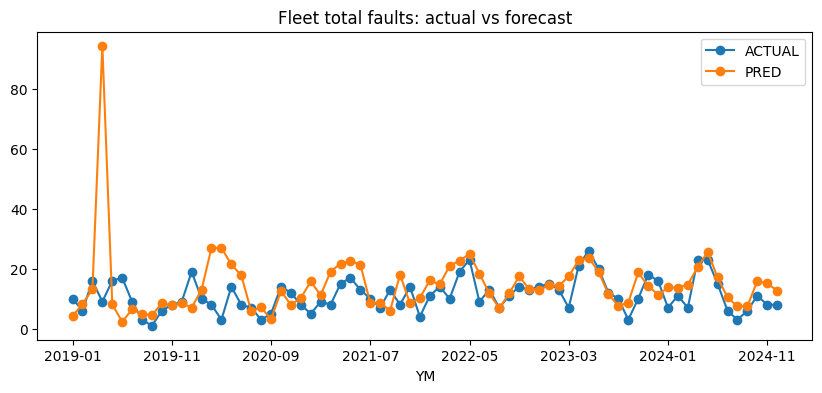

In [ ]:
import matplotlib.pyplot as plt
pm = per_m.groupby(["YM"]).agg(ACTUAL=("ACTUAL","sum"),
                               PRED=("PRED_FAULTS","sum"))
pm.plot(y=["ACTUAL","PRED"], figsize=(10,4), marker='o')
plt.title("Fleet total faults: actual vs forecast"); plt.show()


In [ ]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HT-cable fault-forecast + health-score  (→ forecast year = 2024 only)
--------------------------------------------------------------------
• Train Poisson-LSTM on 2018-2023 targets (24-month context)
• Predict 12-month 2024 faults for every switch
• Compute 2024 health-score using factors c r a f s p i
• Validate on real 2024 faults (confusion matrix & AUROC)
"""

from __future__ import annotations
import logging, numpy as np, pandas as pd
from pathlib import Path
from warnings import filterwarnings
filterwarnings("ignore")

# ───────── user-editable paths ─────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_with_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ───────── constants & hyper-params ────────────────────────────────────────

# ───────── constants ───────────────────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_TARGET_YEARS      = list(range(2018, TARGET_YEAR))      # 2018-2023
KEEP_VOLTAGES, EXPECTED_LIFE_YEARS = {22, 33}, 35

W = dict(c=0.15, r=0.10, a=0.15, f=0.25, s=0.10, p=0.15, i=0.10)     # score weights
BATCH, EPOCHS = 128, 100; LR, WD = 1e-3, 1e-5
HID, LAY, DROP = 128, 2, 0.1; PATIENCE, CLIP = 12, 1.0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG    = 42;  np.random.seed(RNG);  torch.manual_seed(RNG);  torch.cuda.manual_seed_all(RNG)

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s | %(levelname)s | %(message)s")
log = logging.getLogger("pipeline").info

# ═════════════════════════════════ helpers ═════════════════════════════════
def v_to_num(v):
    try: return int(float(str(v).lower().replace("kv","")))
    except: return np.nan

def norm_sw(s: pd.Series) -> pd.Series:
    """
    Strip prefixes, keep digits, turn blanks into NaN, finally Int64 dtype.
    This avoids the empty-string → int() ValueError you saw.
    """
    cleaned = (s.astype(str).str.upper().str.strip()
                 .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
                 .str.replace(r"\D+", "", regex=True)
                 .replace("", np.nan))
    return pd.to_numeric(cleaned, errors="coerce").astype("Int64")

def month_rng(a:int,b:int):            # inclusive a-01 → b-12
    return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def poisson_nll(mu, y):
    mu = mu.clamp_min(1e-8)
    return (mu - y*torch.log(mu)).mean()

def robust(s, lo=5, hi=95):
    c = s.replace([np.inf, -np.inf], np.nan).dropna()
    if c.empty: return pd.Series(0.0, index=s.index)
    a, b = np.percentile(c, [lo, hi])
    return ((s-a).clip(0, b-a)/(b-a+1e-9)).fillna(0.0)

# ═══════════════════ 1.  fault history → monthly counts ════════════════════
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col = "TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"] = norm_sw(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID", "TIME_OUTAGE"])
fault = fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR, TARGET_YEAR)]

if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)]

fault = fault.drop_duplicates(["SWITCH_ID", "TIME_OUTAGE"])
fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")

idx_full = month_rng(MIN_YEAR, TARGET_YEAR)
counts   = (fault[fault["TIME_OUTAGE"].dt.year <= TARGET_YEAR-1]         # ≤ 2023
            .groupby(["SWITCH_ID","YM"]).size()
            .unstack(fill_value=0)
            .reindex(columns=idx_full, fill_value=0)
            .astype(float))

switches = counts.index.tolist();  sw2idx = {sw:i for i,sw in enumerate(switches)}
log(f"Switch universe: {len(switches)}")

# ═══════════════════ 2.  dataset & model ═══════════════════════════════════
class WinSet(Dataset):
    def __init__(self, fr):
        self.X_seq = torch.tensor(fr["X_seq"],    dtype=torch.float32)
        self.X_sea = torch.tensor(fr["X_season"], dtype=torch.float32)
        self.y_seq = torch.tensor(fr["y_seq"],    dtype=torch.float32)
        self.sw    = torch.tensor(fr["sw_idx"],   dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self, i): return self.X_seq[i], self.X_sea[i], self.y_seq[i], self.sw[i]

class LSTM(nn.Module):
    def __init__(self, n_sw, emb=16):
        super().__init__()
        self.emb  = nn.Embedding(n_sw, emb)
        self.rnn  = nn.LSTM(3, HID, LAY, batch_first=True,
                            dropout=DROP if LAY>1 else 0.)
        self.head = nn.Sequential(nn.Linear(HID+emb, HID), nn.ReLU(),
                                  nn.Linear(HID, HID//2),  nn.ReLU(),
                                  nn.Linear(HID//2, 12))
        self.pos  = nn.Softplus()
    def forward(self, x_seq, x_sea, sw):
        x = torch.cat([x_seq, x_sea], -1)
        _, (h, _) = self.rnn(x)
        h = torch.cat([h[-1], self.emb(sw)], 1)
        return self.pos(self.head(h))

def build_frames(years, *, nonzero=True):
    X_seq, X_sea, y_seq, sw_idx = [], [], [], []
    for sw, row in counts.iterrows():
        for Y in years:
            tr = month_rng(Y-2, Y-1);  tg = month_rng(Y, Y)
            if nonzero and row[tr].sum() == 0: continue
            X_seq.append(np.log1p(row.reindex(tr, fill_value=0)).values[:, None])
            X_sea.append(sincos(tr))
            y_seq.append(row.reindex(tg, fill_value=0).values)
            sw_idx.append(sw2idx[sw])
    if not X_seq: return None
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx, dtype=np.int64))

# ═══════════════════ 3. train + forecast ═══════════════════════════════════
train_frames = build_frames(TRAIN_TARGET_YEARS, nonzero=True)
assert train_frames is not None, "No training samples!"

ds   = WinSet(train_frames)
idx  = np.random.permutation(len(ds)); n_val = max(1, int(0.1*len(ds)))
dl_tr = DataLoader(torch.utils.data.Subset(ds, idx[:-n_val]), BATCH, shuffle=True)
dl_va = DataLoader(torch.utils.data.Subset(ds, idx[-n_val:]),  BATCH, shuffle=False)

model = LSTM(len(switches)).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
best, patience = float("inf"), 0

for _ in range(EPOCHS):
    model.train()
    for xb, xbsea, yb, swb in dl_tr:
        xb, xbsea, yb, swb = [t.to(DEVICE) for t in [xb, xbsea, yb, swb]]
        opt.zero_grad(); loss = poisson_nll(model(xb, xbsea, swb), yb)
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), CLIP); opt.step()
    with torch.no_grad():
        v = np.mean([poisson_nll(model(x.to(DEVICE), s.to(DEVICE), w.to(DEVICE)), y.to(DEVICE)).item()
                                  for x, s, y, w in dl_va])
    if v < best - 1e-4: best, patience, best_state = v, 0, model.state_dict()
    else: patience += 1
    if patience >= PATIENCE: break
model.load_state_dict(best_state)
log(f"Final val-loss={best:.4f}")

# ── predict 2024 ───────────────────────────────────────────────────────────
ev_frames = build_frames([TARGET_YEAR], nonzero=False)
dl_ev = DataLoader(WinSet(ev_frames), BATCH, shuffle=False)

MU, SW = [], []
with torch.no_grad():
    for xb, xbsea, _, swb in dl_ev:
        MU.append(model(xb.to(DEVICE), xbsea.to(DEVICE), swb.to(DEVICE)).cpu().numpy())
        SW.append(swb.numpy())
MU, SW = np.concatenate(MU), np.concatenate(SW)

OUT_DIR.mkdir(parents=True, exist_ok=True)
ym_idx = month_rng(TARGET_YEAR, TARGET_YEAR); months = np.arange(1, 13)
rows_m, rows_y = [], []
for i, ix in enumerate(SW):
    sw = switches[ix]
    for m_idx, m in enumerate(months):
        rows_m.append(dict(SWITCH_ID=sw, YEAR=TARGET_YEAR, MONTH=m,
                           YM=str(ym_idx[m_idx]), PRED_FAULTS=float(MU[i, m_idx])))
    rows_y.append(dict(SWITCH_ID=sw, YEAR=TARGET_YEAR, PRED_FULL=float(MU[i].sum())))

per_m = pd.DataFrame(rows_m);  per_y = pd.DataFrame(rows_y)
per_m.to_csv(OUT_DIR/"per_switch_monthly_forecasts_nn.csv", index=False)
per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts_nn.csv",  index=False)
log("Forecast CSVs saved.")

# ═══════════════════ 4. health-score (7 factors) ═══════════════════════════
cables = pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")
today  = pd.Timestamp.utcnow().tz_localize(None)

cab = cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                             "MEASUREDLENGTH":"LENGTH_M",
                             "COMMISSIONEDDATE":"DATE_INSTALLED",
                             "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]      = pd.to_numeric(cab["LENGTH_M"], errors="coerce")/1000
cab["DATE_INSTALLED"] = (pd.to_datetime(cab["DATE_INSTALLED"], errors="coerce", utc=True)
                         .dt.tz_localize(None))

cyc = [c for c in cab.columns if c.startswith("CYCLE_MONTH_")]
var = [c for c in cab.columns if c.startswith("VAR_MONTH_")]
cab["cycle_pm"]       = cab[cyc].mean(1)
cab["load_range_idx"] = cab[var].mean(1)/cab[var].median(1)

hist = fault[fault["TIME_OUTAGE"].dt.year <= 2023].groupby("SWITCH_ID").size()
cab  = cab.merge(hist.rename("hist_faults"), on="SWITCH_ID", how="left").fillna({"hist_faults": 0})
cab  = cab.merge(per_y, on="SWITCH_ID", how="left").fillna({"PRED_FULL": 0}) \
           .rename(columns={"PRED_FULL": "pred_faults_2024"})

cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"] = pd.to_numeric(
    cab.get("FAULT_TIME_DIFFERENCE_HOURS_AVG"), errors="coerce")
default_int = cab["DATE_INSTALLED"].apply(lambda x: (today - x).total_seconds()/3600)
cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].fillna(default_int, inplace=True)

cab["a_raw"] = ((today - cab["DATE_INSTALLED"]).dt.days)/(EXPECTED_LIFE_YEARS*365)
cab["c_raw"] = cab["cycle_pm"];        cab["r_raw"] = cab["load_range_idx"]
cab["f_raw"] = cab["hist_faults"]/cab["LENGTH_KM"].replace(0, np.nan)
cab["s_raw"] = (cab["SEGMENTS"]-1).clip(lower=0)
cab["p_raw"] = cab["pred_faults_2024"]/cab["LENGTH_KM"].replace(0, np.nan)
cab["i_raw"] = 1/cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].clip(lower=1)

for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw"]:
    cab[col[0]] = robust(cab[col])

baseline = sum(W[k]*cab[k] for k in ["c","r","a","f","s","i"])
fleet24  = cab["pred_faults_2024"].sum()
cab["q"] = baseline/baseline.sum()
cab["pred_faults_2024_dist"] = cab["q"]*fleet24
cab["p_raw"] = cab["pred_faults_2024_dist"]/cab["LENGTH_KM"].replace(0, np.nan)
cab["p"] = robust(cab["p_raw"])

risk = sum(W[k]*cab[k] for k in ["c","r","a","f","s","p","i"])
cab["health_score"] = (100*(1-risk)).clip(0,100)
cab["health_band"]  = pd.cut(cab["health_score"],
                             [-np.inf, 35, 79, 100],
                             labels=["Poor","Moderate","Good"])
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv", index=False)
log("Health-score CSV saved.")

# ═══════════════════ 5. validation (confusion-matrix & AUROC) ══════════════
actual = fault[fault["TIME_OUTAGE"].dt.year == 2024]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"] = cab["SWITCH_ID"].isin(actual).astype(int)
pred = cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm   = confusion_matrix(cab["ACTUAL_FAIL_24"], pred)
au   = roc_auc_score(cab["ACTUAL_FAIL_24"], 100 - cab["health_score"])

log(f"\n2024 confusion matrix:\n{cm}\nAUROC={au:.3f}")
log("✓ Pipeline complete → "+str(OUT_DIR.resolve()))

2025-07-31 13:15:47,377 | INFO | Switch universe: 210
2025-07-31 13:15:48,688 | INFO | Final val-loss=0.3003
2025-07-31 13:15:48,835 | INFO | Forecast CSVs saved.
2025-07-31 13:15:48,906 | INFO | Health-score CSV saved.
2025-07-31 13:15:48,912 | INFO | 
2024 confusion matrix:
[[109  75]
 [ 24  48]]
AUROC=0.667
2025-07-31 13:15:48,913 | INFO | ✓ Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [ ]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  HT-cable Poisson-LSTM forecast + 7-factor health-score (2018-2024)  ║
# ╚══════════════════════════════════════════════════════════════════════╝
from __future__ import annotations
import logging, math, os, sys, numpy as np, pandas as pd, torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ──── constants / hyper-params ────────────────────────────────────────────
MIN_YEAR, TARGET_YEAR      = 2016, 2024
TRAIN_YEARS                = list(range(2018, TARGET_YEAR))   # 2018-2023
KEEP_VOLTAGES              = {22, 33}
EXPECTED_LIFE_YEARS        = 35
W                          = dict(c=.15, r=.10, a=.15, f=.25, s=.10, p=.15, i=.10)
BATCH, EPOCHS, PATIENCE    = 128, 100, 12
LR, WD, CLIP               = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB        = 128, 2, 0.1, 16
DEVICE                     = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42);  np.random.seed(42)

# ──── logging ────────────────────────────────────────────────────────────
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ──── small helpers ───────────────────────────────────────────────────────
def v_to_num(v):     # "22kV" → 22
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(col: pd.Series) -> pd.Series:
    s = (col.astype(str).str.upper().str.strip()
         .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
         .str.replace(r"\D+", "", regex=True)
         .replace("", np.nan))
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def month_range(a:int,b:int):           # inclusive a-01 … b-12
    return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def robust(series, lo=5, hi=95):
    c = series.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=series.index)
    a,b = np.percentile(c, [lo,hi]); denom = (b-a+1e-9)
    return ((series-a).clip(0,b-a)/denom).fillna(0.)

# ──── 1.  load + preprocess faults → monthly counts ───────────────────────
log("Loading fault CSV …")
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col = "TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"] = norm_sw(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault = fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR, TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault = fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")

idx_full = month_range(MIN_YEAR, TARGET_YEAR)
counts = (fault[fault["TIME_OUTAGE"].dt.year <= TARGET_YEAR-1]
          .groupby(["SWITCH_ID","YM"]).size()
          .unstack(fill_value=0)
          .reindex(columns=idx_full, fill_value=0)
          .astype(float))
switches = counts.index.tolist(); sw2idx = {sw:i for i,sw in enumerate(switches)}
log(f"Switch universe = {len(switches)}")

# ──── 2.  dataset + model ────────────────────────────────────────────────
# ──── 2.  dataset + model ────────────────────────────────────────────────
class WinDS(Dataset):
    """
    Window-level dataset:
      • x   : [n, 24, 1]      (log-count context)
      • xs  : [n, 24, 2]      (sin / cos seasonality)
      • y   : [n, 12]         (target year monthly counts)
      • sw  : [n]             (switch index for embedding)
    """
    def __init__(self, frames: dict[str, np.ndarray]):
        self.x   = torch.tensor(frames["X_seq"],    dtype=torch.float32)
        self.xs  = torch.tensor(frames["X_season"], dtype=torch.float32)
        self.y   = torch.tensor(frames["y_seq"],    dtype=torch.float32)
        self.sw  = torch.tensor(frames["sw_idx"],   dtype=torch.long)

    def __len__(self):  return len(self.sw)

    def __getitem__(self, i: int):
        return self.x[i], self.xs[i], self.y[i], self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self, n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3, HID, LAY, batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head = nn.Sequential(nn.Linear(HID+EMB, HID), nn.ReLU(),
                                  nn.Linear(HID, HID//2),  nn.ReLU(),
                                  nn.Linear(HID//2, 12))
        self.sp = nn.Softplus()
    def forward(self, x, xs, sw):
        h, _ = self.rnn(torch.cat([x, xs], -1))
        h = torch.cat([h[:,-1], self.emb(sw)], 1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx = [],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr = month_range(Y-2, Y-1); tg = month_range(Y, Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    if not X_seq: return None
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames = build_frames(TRAIN_YEARS, nonzero=True)
assert train_frames, "No training samples!"
ds = WinDS(train_frames)
perm = np.random.permutation(len(ds)); n_val = max(1,int(.1*len(ds)))
dl_tr = DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va = DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model = PoissonLSTM(len(switches)).to(DEVICE)
loss_fn = nn.PoissonNLLLoss(log_input=False)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
best,bad=1e9,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss = loss_fn(model(xb,xs,swb), yb)
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        vloss=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),y.to(DEVICE)).item()
                       for x,xs,y,sw in dl_va])
    log(f"ep {ep:03d}  val {vloss:.4f}")
    if vloss<best-1e-4: best,bad,ckpt=vloss,0,model.state_dict()
    else: bad+=1
    if bad>=PATIENCE: break
model.load_state_dict(ckpt); log(f"Best val-loss={best:.4f}")

# ──── 3.  forecast 2024 ───────────────────────────────────────────────────
eval_frames = build_frames([TARGET_YEAR], nonzero=False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy()); swids.append(swb.cpu().numpy())
MU = np.concatenate(mu); SWIDX=np.concatenate(swids)
ym_idx=month_range(TARGET_YEAR,TARGET_YEAR); months=np.arange(1,13)
rows_m,rows_y=[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw, YEAR=TARGET_YEAR, PRED_FULL=float(MU[i].sum())))
    for m_idx,m in enumerate(months):
        rows_m.append(dict(SWITCH_ID=sw, YEAR=TARGET_YEAR, MONTH=m,
                           YM=str(ym_idx[m_idx]), PRED_FAULTS=float(MU[i,m_idx])))
OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
per_y = pd.DataFrame(rows_y); per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)
log("Forecast CSVs saved → %s", OUT_DIR)

# ──── 4.  health-score (identical logic to your original) ─────────────────
cables = pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")
today = pd.Timestamp.utcnow().tz_localize(None)
cab = cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                             "MEASUREDLENGTH":"LENGTH_M",
                             "COMMISSIONEDDATE":"DATE_INSTALLED",
                             "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"] = pd.to_numeric(cab["LENGTH_M"], errors="coerce")/1000
cab["DATE_INSTALLED"] = (pd.to_datetime(cab["DATE_INSTALLED"], errors="coerce", utc=True)
                         .dt.tz_localize(None))
cyc=[c for c in cab.columns if c.startswith("CYCLE_MONTH_")]
var=[c for c in cab.columns if c.startswith("VAR_MONTH_")]
cab["cycle_pm"]=cab[cyc].mean(1); cab["load_range_idx"]=cab[var].mean(1)/cab[var].median(1)
hist = fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1].groupby("SWITCH_ID").size()
cab = cab.merge(hist.rename("hist_faults"), on="SWITCH_ID", how="left").fillna({"hist_faults":0})
cab = cab.merge(per_y, on="SWITCH_ID", how="left").fillna({"PRED_FULL":0}) \
         .rename(columns={"PRED_FULL":"pred_faults_2024"})
cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"] = pd.to_numeric(
        cab.get("FAULT_TIME_DIFFERENCE_HOURS_AVG"), errors="coerce")
default_int = cab["DATE_INSTALLED"].apply(lambda x:(today-x).total_seconds()/3600)
cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].fillna(default_int,inplace=True)
cab["a_raw"]=((today - cab["DATE_INSTALLED"]).dt.days)/(EXPECTED_LIFE_YEARS*365)
cab["c_raw"]=cab["cycle_pm"]; 
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"]-1).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["i_raw"]=1/cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].clip(lower=1)
for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw"]:
    cab[col[0]] = robust(cab[col])
baseline=sum(W[k]*cab[k] for k in ["c","r","a","f","s","i"])
fleet24 = cab["pred_faults_2024"].sum()
cab["q"]=baseline/baseline.sum(); cab["pred_faults_2024_dist"]=cab["q"]*fleet24
cab["p_raw"]=cab["pred_faults_2024_dist"]/cab["LENGTH_KM"].replace(0,np.nan); cab["p"]=robust(cab["p_raw"])
risk=sum(W[k]*cab[k] for k in ["c","r","a","f","s","p","i"])
cab["health_score"]=(100*(1-risk)).clip(0,100)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,35,79,100],labels=["Poor","Moderate","Good"])
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)

# ──── 5.  validation ───────────────────────────────────────────────────────
actual = fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred = cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm = confusion_matrix(cab["ACTUAL_FAIL_24"], pred)
au = roc_auc_score(cab["ACTUAL_FAIL_24"], 100-cab["health_score"])
log(f"\n2024 confusion-matrix:\n{cm}\nAUROC={au:.3f}")
log("✓ Pipeline complete → %s", OUT_DIR.resolve())


2025-07-31 13:07:08,025 | INFO | Loading fault CSV …
2025-07-31 13:07:08,196 | INFO | Switch universe = 210
2025-07-31 13:07:08,933 | INFO | ep 001  val 0.7058
2025-07-31 13:07:08,970 | INFO | ep 002  val 0.6558
2025-07-31 13:07:09,005 | INFO | ep 003  val 0.4249
2025-07-31 13:07:09,045 | INFO | ep 004  val 0.3396
2025-07-31 13:07:09,089 | INFO | ep 005  val 0.3559
2025-07-31 13:07:09,133 | INFO | ep 006  val 0.3054
2025-07-31 13:07:09,181 | INFO | ep 007  val 0.3003
2025-07-31 13:07:09,247 | INFO | ep 008  val 0.3011
2025-07-31 13:07:09,294 | INFO | ep 009  val 0.3071
2025-07-31 13:07:09,337 | INFO | ep 010  val 0.3121
2025-07-31 13:07:09,424 | INFO | ep 011  val 0.3065
2025-07-31 13:07:09,469 | INFO | ep 012  val 0.3033
2025-07-31 13:07:09,512 | INFO | ep 013  val 0.3015
2025-07-31 13:07:09,575 | INFO | ep 014  val 0.3032
2025-07-31 13:07:09,614 | INFO | ep 015  val 0.3051
2025-07-31 13:07:09,662 | INFO | ep 016  val 0.3025
2025-07-31 13:07:09,721 | INFO | ep 017  val 0.3022
2025-07-

In [ ]:
from sklearn.metrics import roc_curve, classification_report
fpr,tpr,_ = roc_curve(cab["ACTUAL_FAIL_24"], 100-cab["health_score"])
print(classification_report(cab["ACTUAL_FAIL_24"], pred, digits=3))


              precision    recall  f1-score   support

           0      0.800     0.674     0.732       184
           1      0.406     0.569     0.474        72

    accuracy                          0.645       256
   macro avg      0.603     0.622     0.603       256
weighted avg      0.689     0.645     0.659       256



In [16]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  HT-cable Poisson-LSTM forecast + 7-factor health-score (2018-2024) ║
# ╚══════════════════════════════════════════════════════════════════════╝
from __future__ import annotations
import logging, math, sys, numpy as np, pandas as pd, torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ─── user-editable paths ────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_with_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants & hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35
W = dict(c=.15, r=.10, a=.15, f=.25, s=.10, p=.15, i=.10)
BATCH, EPOCHS, PATIENCE = 128, 100, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 128, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

# ─── logging ────────────────────────────────────────────────────────────
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper utils ────────────────────────────────────────────────────────
def v_to_num(v):     # "22kV" → 22
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s: pd.Series) -> pd.Series:
    cleaned = (s.astype(str).str.upper().str.strip()
                 .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
                 .str.replace(r"\D+", "", regex=True)
                 .replace("", np.nan))
    return pd.to_numeric(cleaned, errors="coerce").astype("Int64")

def month_range(a:int,b:int):
    return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def robust(s, lo=5, hi=95):
    c = s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b = np.percentile(c, [lo,hi])
    return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

def months_to_quarters(mat_12: np.ndarray) -> np.ndarray:
    q = np.zeros((mat_12.shape[0], 4), dtype=float)
    q[:,0] = mat_12[:,0:3 ].sum(1); q[:,1] = mat_12[:,3:6 ].sum(1)
    q[:,2] = mat_12[:,6:9 ].sum(1); q[:,3] = mat_12[:,9:12].sum(1)
    return q

# ─── 1 · load faults → monthly counts ────────────────────────────────────
log("Loading fault CSV …")
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col = "TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"] = norm_sw(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault = fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR, TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault = fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")

idx_full = month_range(MIN_YEAR, TARGET_YEAR)
counts = (fault[fault["TIME_OUTAGE"].dt.year <= TARGET_YEAR-1]
          .groupby(["SWITCH_ID","YM"]).size()
          .unstack(fill_value=0)
          .reindex(columns=idx_full, fill_value=0)
          .astype(float))
switches = counts.index.tolist(); sw2idx = {sw:i for i,sw in enumerate(switches)}
log(f"Switch universe = {len(switches)}")

# ─── 2 · dataset & model ────────────────────────────────────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],    dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"], dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],    dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],   dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i], self.xs[i], self.y[i], self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3, HID, LAY, batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head = nn.Sequential(nn.Linear(HID+EMB, HID), nn.ReLU(),
                                  nn.Linear(HID, HID//2), nn.ReLU(),
                                  nn.Linear(HID//2, 12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_ = self.rnn(torch.cat([x,xs],-1))
        h = torch.cat([h[:,-1], self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years,*,nonzero=True):
    X_seq,X_sea,y_seq,sw_idx = [],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr = month_range(Y-2,Y-1); tg = month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    if not X_seq: return None
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames = build_frames(TRAIN_YEARS, nonzero=True)
ds = WinDS(train_frames); perm = np.random.permutation(len(ds))
n_val = max(1,int(0.1*len(ds)))
dl_tr = DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_val= DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model = PoissonLSTM(len(switches)).to(DEVICE)
loss_fn, opt = nn.PoissonNLLLoss(log_input=False), torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad = 1e9,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); L = loss_fn(model(xb,xs,swb), yb)
        L.backward(); nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v = np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),y.to(DEVICE)).item()
                     for x,xs,y,sw in dl_val])
    log(f"ep {ep:03d}  val {v:.4f}")
    if v < best-1e-4: best,bad,ckpt = v,0,model.state_dict()
    else: bad += 1
    if bad >= PATIENCE: break
model.load_state_dict(ckpt); log(f"Best val-loss = {best:.4f}")

# ─── 3 · forecast 2024 (monthly / quarterly / yearly) ────────────────────
eval_frames = build_frames([TARGET_YEAR], nonzero=False)
mu,swids = [],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy()); swids.append(swb.cpu().numpy())
MU    = np.concatenate(mu); SWIDX=np.concatenate(swids)
QTRS  = months_to_quarters(MU)

ym_idx = month_range(TARGET_YEAR,TARGET_YEAR); months=np.arange(1,13)
rows_m,rows_q,rows_y = [],[],[]
for i,ix in enumerate(SWIDX):
    sw = switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m_idx,m in enumerate(months):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=int(m),
                           YM=str(ym_idx[m_idx]),PRED_FAULTS=float(MU[i,m_idx])))
    for q_idx,q_sum in enumerate(QTRS[i],start=1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,
                           QUARTER=int(q_idx),PRED_FAULTS_Q=float(q_sum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
per_y = pd.DataFrame(rows_y)
per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)
log("Forecast CSVs saved  %s", OUT_DIR)

# ─── 4 · health-score + 1-10 rating + TOP-3 drivers ───────────────────────
cables = pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")
today  = pd.Timestamp.utcnow().tz_localize(None)

cab = cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                             "MEASUREDLENGTH":"LENGTH_M",
                             "COMMISSIONEDDATE":"DATE_INSTALLED",
                             "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]      = pd.to_numeric(cab["LENGTH_M"], errors="coerce")/1000
cab["DATE_INSTALLED"] = (pd.to_datetime(cab["DATE_INSTALLED"], errors="coerce", utc=True)
                         .dt.tz_localize(None))
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]       = cab[cyc].mean(1)
cab["load_range_idx"] = cab[var].mean(1)/cab[var].median(1)

hist = fault[fault["TIME_OUTAGE"].dt.year <= TARGET_YEAR-1] \
          .groupby("SWITCH_ID").size()
cab  = cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})
cab  = cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
                 on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"] = pd.to_numeric(
        cab.get("FAULT_TIME_DIFFERENCE_HOURS_AVG"), errors="coerce")
default_int = cab["DATE_INSTALLED"].apply(lambda x:(today-x).total_seconds()/3600)
cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].fillna(default_int,inplace=True)

cab["a_raw"] = ((today - cab["DATE_INSTALLED"]).dt.days)/(EXPECTED_LIFE_YEARS*365)
cab["c_raw"] = cab["cycle_pm"];        
cab["r_raw"] = cab["load_range_idx"]
cab["f_raw"] = cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"] = (cab["SEGMENTS"]-1).clip(lower=0)
cab["p_raw"] = cab["pred_faults_2024"]/cab["LENGTH_KM"].replace(0,np.nan)
# keep direction: bigger MTTR = worse
# cab["i_raw"] = 1/cab["FAULT_TIME_DIFFERENCE_HOURS_AVG"].clip(lower=1)  # ensure finite
# ─── build i_raw  from inter-arrival times  ─────────────────────────────
# 1) sort events chronologically inside each switch
fault_sorted = fault.sort_values(["SWITCH_ID", "TIME_OUTAGE"]).copy()

# 2) Δt = current outage − previous outage  (hours)
fault_sorted["Δt_hours"] = (
    fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
                .diff()                      # pandas Timedelta
                .dt.total_seconds()
                .div(3600)                   # convert to hours
)

# 3) mean inter-arrival time per switch (skip the NaN for the first event)
mean_dt = (fault_sorted.groupby("SWITCH_ID")["Δt_hours"]
                         .mean()
                         .rename("mean_inter_hours"))

# 4) merge into cable table
cab = cab.merge(mean_dt, on="SWITCH_ID", how="left")

# 5) i_raw = failure-rate  = 1 / mean(Δt)   (clip so we never divide by 0)
cab["i_raw"] = 1 / cab["mean_inter_hours"].clip(lower=1)

for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw"]:
    cab[col[0]] = robust(cab[col])

baseline = sum(W[k]*cab[k] for k in ["c","r","a","f","s","i"])
fleet24  = cab["pred_faults_2024"].sum()
cab["q"] = baseline/baseline.sum()
cab["pred_faults_2024_dist"] = cab["q"]*fleet24
cab["p_raw"] = cab["pred_faults_2024_dist"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["p"] = robust(cab["p_raw"])

risk = sum(W[k]*cab[k] for k in ["c","r","a","f","s","p","i"])
cab["health_score"] = (100*(1-risk)).clip(0,100)       # make sure NumPy is imported

cab["health_score"] = np.rint(100 * (1 - risk)).clip(0, 100).astype(int)

cab["health_band"]  = pd.cut(cab["health_score"],[-np.inf,40,77,100],
                             labels=["Poor","Moderate","Good"])

cab["health_score_10"] = np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)

# ─── NEW banding rule: 1-4 Poor, 5-7 Moderate, 8-10 Good ───────────────
# cab["health_band"] = pd.cut(
#         cab["health_score_10"],
#         [-np.inf, 4, 8, 10],
#         labels=["Poor", "Moderate", "Good"]
# )

# ―― TOP-3 drivers, with override for “very healthy” cables ―──────────────
risk_contrib = pd.DataFrame({k: W[k]*cab[k] for k in ["c","r","a","f","s","p","i"]})
factor_keys   = np.array(["c","r","a","f","s","p","i"])
LABELS = {
    "c":"high load cycles (c)",
    "r":"wide load range (r)",
    "a":"advanced age (a)",
    "f":"many historic faults (f)",
    "s":"many joints/segments (s)",
    "p":"high predicted faults/km (p)",
    "i":"frequent interruptions (i)"
}
top3_idx    = np.argsort(risk_contrib.values, axis=1)[:, -3:][:, ::-1]
top3_labels = [[LABELS[factor_keys[j]] for j in row] for row in top3_idx]

cab["primary_health_driver"] = [lbls[0] for lbls in top3_labels]
cab["top3_health_drivers"]   = ["; ".join(lbls) for lbls in top3_labels]

# override if score is perfect OR predicted faults == 0
mask_healthy = (cab["health_score_10"] == 10) | (cab["pred_faults_2024"] == 0)
cab.loc[mask_healthy, "primary_health_driver"] = "— none (very healthy)"
cab.loc[mask_healthy, "top3_health_drivers"]   = "All factors within safe range"

cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)

# ─── 5 · validation ─────────────────────────────────────────────────────
actual = fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"] = cab["SWITCH_ID"].isin(actual).astype(int)
pred = cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm = confusion_matrix(cab["ACTUAL_FAIL_24"], pred)
au = roc_auc_score(cab["ACTUAL_FAIL_24"], 100-cab["health_score"])

log(f"\n2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log(" Pipeline complete %s", OUT_DIR.resolve())


17:43:35 | Loading fault CSV …


17:43:35 | Switch universe = 210


/tmp/ipykernel_172021/1818176657.py:76: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")


17:43:36 | ep 001  val 0.7058
17:43:36 | ep 002  val 0.6559
17:43:36 | ep 003  val 0.4252
17:43:36 | ep 004  val 0.3369
17:43:37 | ep 005  val 0.3567
17:43:37 | ep 006  val 0.3046
17:43:37 | ep 007  val 0.3017
17:43:37 | ep 008  val 0.3009
17:43:37 | ep 009  val 0.3079
17:43:37 | ep 010  val 0.3129
17:43:38 | ep 011  val 0.3056
17:43:38 | ep 012  val 0.3014
17:43:38 | ep 013  val 0.3017
17:43:38 | ep 014  val 0.3048
17:43:38 | ep 015  val 0.3037
17:43:39 | ep 016  val 0.3031
17:43:39 | ep 017  val 0.3030
17:43:39 | ep 018  val 0.3029
17:43:39 | ep 019  val 0.3026
17:43:39 | ep 020  val 0.3044
17:43:39 | Best val-loss = 0.3009
17:43:39 | Forecast CSVs saved  /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health
17:43:39 | 
2024 confusion matrix:
[[113  71]
 [ 29  43]]
AUROC = 0.623
17:43:39 |  Pipeline complete /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [ ]:
# ----- columns you don't want in the final CSV -------------------------
cols_to_remove = [
    "NUMBEROFCORES", "ARMOURED", "NEUTRALMATERIAL", "CABLEID",
    "CABLECONDUCTORMATERIAL", "DIVISIONCODE", "ZONECODE",
    "FAULT_DIVISION",      # appears twice in your list―one name is enough
    "IR_Measurement_MOhm", "Tan_Delta",
    "Partial_Discharge_Frequency", "Partial_Discharge_Intensity",
    "SWITCH_NO"            # duplicate of SWITCH_ID in some master tables
]

cab = cab.drop(columns=[c for c in cols_to_remove if c in cab.columns])


In [ ]:
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv", index=False)


NameError: name 'cab' is not defined

Heaalth score with other attribute 


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
HT-cable Poisson-LSTM forecast + 9-factor health score (2018-2024)
2025-08-06 — full driver labels + weight columns
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
import torch, torch.nn as nn
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ─── paths ──────────────────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_with_affected.csv")
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL4.csv")
OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")

# ─── constants / hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))
KEEP_VOLTAGES           = {22, 33}
EXPECTED_LIFE_YEARS     = 35

# 9-factor weights (p = 15 %; other eight share 85 %)
W = dict(  a= 0.01941,
  c= 0.03371,
  f= 0.12157,
  i= 0.10727,
  l= 0.27278,
  p= 0.15000,
  r= 0.04904,
  s= 0.06028,
  u= 0.18594 )   #  ←

BATCH, EPOCHS, PATIENCE = 128, 100, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 128, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper functions (unchanged) ───────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def month_range(a,b): return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def robust(s, lo=5, hi=95):
    c=s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b=np.percentile(c,[lo,hi]); return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

# ─── 1 · fault history  (identical logic) ───────────────────────────────
fault=pd.read_csv(FAULT_CSV,parse_dates=["TIME_OUTAGE"],low_memory=False)
sw_col="TO_SWITCH" if "TO_SWITCH" in fault.columns else fault.columns[0]
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")

idx_full=month_range(MIN_YEAR,TARGET_YEAR)
counts=(fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]
        .groupby(["SWITCH_ID","YM"]).size()
        .unstack(fill_value=0)
        .reindex(columns=idx_full,fill_value=0).astype(float))
switches=counts.index.tolist(); sw2idx={sw:i for i,sw in enumerate(switches)}

# ─── 2 · Poisson-LSTM dataset & training  (unchanged) ───────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"],dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i],self.xs[i],self.y[i],self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3,HID,LAY,batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head=nn.Sequential(nn.Linear(HID+EMB,HID),nn.ReLU(),
                                nn.Linear(HID,HID//2),nn.ReLU(),
                                nn.Linear(HID//2,12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_=self.rnn(torch.cat([x,xs],-1))
        h=torch.cat([h[:,-1],self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr,tg=month_range(Y-2,Y-1),month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames=build_frames(TRAIN_YEARS,True)
ds=WinDS(train_frames); perm=np.random.permutation(len(ds))
n_val=max(1,int(.1*len(ds)))
dl_tr=DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va=DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model=PoissonLSTM(len(switches)).to(DEVICE)
loss_fn,opt=nn.PoissonNLLLoss(log_input=False),torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad,best_ep=1e9,0,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss_fn(model(xb,xs,swb),yb).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),
                           y.to(DEVICE)).item()
                   for x,xs,y,sw in dl_va])
    if v<best-1e-4: best,bad,best_ep,ckpt=v,0,ep,model.state_dict()
    else: bad+=1
    if bad>=PATIENCE: break
model.load_state_dict(ckpt)
log(f"Training finished in {best_ep} epochs | best val-loss={best:.4f}")

# ─── 3 · 2024 forecasts  (unchanged) ────────────────────────────────────
eval_frames=build_frames([TARGET_YEAR],False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy())
        swids.append(swb.cpu().numpy())
MU,SWIDX=np.concatenate(mu),np.concatenate(swids)
QTRS=months_to_quarters(MU)

ym=month_range(TARGET_YEAR,TARGET_YEAR)
rows_m,rows_q,rows_y=[],[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m in range(12):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=m+1,
                           YM=str(ym[m]),PRED_FAULTS=float(MU[i,m])))
    for qi,qsum in enumerate(QTRS[i],1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,QUARTER=qi,
                           PRED_FAULTS_Q=float(qsum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
per_y=pd.DataFrame(rows_y)
per_y.to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)

# ─── 4 · health score (9 factors) ───────────────────────────────────────
cables=pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("DESTINATION_SWITCH_ID")
today=pd.Timestamp.utcnow().tz_localize(None)

cab=cables.rename(columns={"DESTINATION_SWITCH_ID":"SWITCH_ID",
                           "MEASUREDLENGTH":"LENGTH_M",
                           "COMMISSIONEDDATE":"DATE_INSTALLED",
                           "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]=pd.to_numeric(cab["LENGTH_M"],errors="coerce")/1000
cab["DATE_INSTALLED"]=(pd.to_datetime(cab["DATE_INSTALLED"],errors="coerce",utc=True)
                       .dt.tz_localize(None))
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]=cab[cyc].mean(1)
cab["load_range_idx"]=cab[var].mean(1)/cab[var].median(1)

hist=fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1] \
        .groupby("SWITCH_ID").size()
cab=cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})
cab=cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
              on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

fault_sorted=fault.sort_values(["SWITCH_ID","TIME_OUTAGE"])
fault_sorted["Δt_h"]=(fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
                      .diff().dt.total_seconds().div(3600))
mean_dt=fault_sorted.groupby("SWITCH_ID")["Δt_h"].mean().rename("mean_h")
cab=cab.merge(mean_dt,on="SWITCH_ID",how="left")

recent_cut=(pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8))
recent_cnt=(fault[fault["TIME_OUTAGE"]>=recent_cut].groupby("SWITCH_ID").size())
cab=cab.merge(recent_cnt.rename("recent8"),on="SWITCH_ID",how="left").fillna({"recent8":0})

cab["a_raw"]=(today.day - cab["DATE_INSTALLED"].dt.day) / (EXPECTED_LIFE_YEARS * 365)
cab["c_raw"]=cab["cycle_pm"]
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"].fillna(1)-1).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"]=1/cab["mean_h"].clip(lower=1)
cab["l_raw"]=np.log1p(cab["LENGTH_KM"])    # length factor
cab["u_raw"]=cab["recent8"]/cab["LENGTH_KM"].replace(0,np.nan)

for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw",
            "i_raw","l_raw","u_raw"]:
    cab[col[0]]=robust(cab[col])

# risk & score
risk=sum(W[k]*cab[k] for k in W.keys())
cab["health_score"]=np.rint(100*(1-risk)).clip(0,100).astype(int)
cab["health_score_10"]=np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,40,61,100],
                          labels=["Poor","Moderate","Good"])

# add constant weight columns
for k,wv in W.items():
    cab[f"weight_{k}"] = wv

# driver labels
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range utilisation (r)",
    "a":"Advanced cable age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous joints / segments (s)",
    "p":"High predicted faults per km (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long circuit length (ℓ)",
    "u":"Recent-8-month faults per km (u)"
}
risk_contrib=pd.DataFrame({k:W[k]*cab[k] for k in W.keys()})
top3=risk_contrib.apply(lambda r:r.nlargest(3).index.tolist(),axis=1)
cab["primary_health_driver"]=top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]=top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

mask_nofault=(cab["hist_faults"].eq(0)&cab["recent8"].eq(0))
cab.loc[mask_nofault,["health_score","health_score_10"]]=[100,10]
cab.loc[mask_nofault,"health_band"]="Good"
cab.loc[mask_nofault,"primary_health_driver"]="No recorded faults"
cab.loc[mask_nofault,"top3_health_drivers"]="No recorded faults"

# save CSVs
# The 'pred_faults_2024' column is already in the 'cab' DataFrame and will be saved.
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)

predict_mask=~mask_nofault
cab_pred=cab[predict_mask]
cab_pred.to_csv(OUT_DIR/"cable_health_2024_predictions.csv",index=False)
log(f"Saved predictions for {len(cab_pred)} cables -> cable_health_2024_predictions.csv")

#  save weights as JSON for transparency
with open(OUT_DIR/"factor_weights.json","w",encoding="utf-8") as fp:
    json.dump(W, fp, indent=2)

# validation
actual=fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred=cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm=confusion_matrix(cab["ACTUAL_FAIL_24"],pred)
au=roc_auc_score(cab["ACTUAL_FAIL_24"],100-cab["health_score"])
log(f"\n2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log("Factor weights applied: "+json.dumps(W))
log(" Pipeline complete → %s", OUT_DIR.resolve())

/tmp/ipykernel_37010/885947935.py:87: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")


00:19:44 | Training finished in 7 epochs | best val-loss=0.3003
00:19:44 | Saved predictions for 190 cables -> cable_health_2024_predictions.csv
00:19:44 | 
2024 confusion matrix:
[[140  44]
 [ 18  54]]
AUROC = 0.849
00:19:44 | Factor weights applied: {"a": 0.01941, "c": 0.03371, "f": 0.12157, "i": 0.10727, "l": 0.27278, "p": 0.15, "r": 0.04904, "s": 0.06028, "u": 0.18594}
00:19:44 |  Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health


In [18]:
df = pd.read_csv(OUT_DIR/"cable_health_2024_scored.csv")

In [19]:
print(len(df['SWITCH_ID']), "unique SWITCH_IDs in the final health score CSV.")

256 unique SWITCH_IDs in the final health score CSV.


Attribute analysis 

In [90]:
# ─────────────────────────────────────────────────────────────────────────────
# 7 · Year-generalized panel + feature importance (uses ALL faults up to 2024)
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# ─── Config ─────────────────────────────────────────────────────────────────
OUT_DIR = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health")
EXPECTED_LIFE_YEARS = 35.0
N_THREADS = 3

for k in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS",
          "VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[k] = str(N_THREADS)

(OUT_DIR / "CORR").mkdir(parents=True, exist_ok=True)

def log(msg, *args): print(msg % args if args else msg)

# ─── Preconditions ─────────────────────────────────────────────────────────
req_fault_cols = {"SWITCH_ID","TIME_OUTAGE"}
req_cab_cols   = {"SWITCH_ID","LENGTH_KM","SEGMENTS","cycle_pm","load_range_idx","DATE_INSTALLED"}
missing_f = req_fault_cols - set(globals().get("fault", pd.DataFrame()).columns)
missing_c = req_cab_cols   - set(globals().get("cab",   pd.DataFrame()).columns)
if missing_f or missing_c:
    raise RuntimeError(f"Missing columns — fault: {missing_f}, cab: {missing_c}")

# ─── Ensure TIME_OUTAGE is tz-aware UTC ────────────────────────────────────
fault["TIME_OUTAGE"] = pd.to_datetime(fault["TIME_OUTAGE"], errors="coerce", utc=True)

# Precompute inter-fault deltas (hours) once for MTBF
fault_sorted = fault.sort_values(["SWITCH_ID", "TIME_OUTAGE"]).copy()
fault_sorted["dt_hours"] = (
    fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
    .diff()
    .dt.total_seconds()
    .div(3600)
)

# ─── Build per-switch, per-year panel (history up to Jan 1 of year y) ─────
min_y = int(fault["TIME_OUTAGE"].dt.year.min())
max_y = int(fault["TIME_OUTAGE"].dt.year.max())
years = list(range(max(min_y + 1, 2016), max_y + 1))

panel_rows = []
for y in years:
    B    = pd.Timestamp(f"{y}-01-01", tz="UTC")
    Bm12 = B - pd.DateOffset(years=1)
    Bm24 = B - pd.DateOffset(years=2)

    # history ≤ B-1day (no leakage)
    hist = fault_sorted[fault_sorted["TIME_OUTAGE"] < B]

    # next-year target (fault occurs in year y)
    tgt  = (fault_sorted[fault_sorted["TIME_OUTAGE"].dt.year == y]
            .groupby("SWITCH_ID").size().rename("TARGET_FAULT")).astype(int)

    # counts in history
    hist_cnt  = hist.groupby("SWITCH_ID").size().rename("hist_faults_cum")
    recent12  = hist[hist["TIME_OUTAGE"] >= Bm12].groupby("SWITCH_ID").size().rename("recent_12m")
    recent24  = hist[hist["TIME_OUTAGE"] >= Bm24].groupby("SWITCH_ID").size().rename("recent_24m")
    last_time = hist.groupby("SWITCH_ID")["TIME_OUTAGE"].max().rename("last_fault_time")

    # MTBF (hours) in history up to B
    mtbf_h = (hist.groupby("SWITCH_ID")["dt_hours"].mean()
                  .rename("mtbf_hours"))

    feat = cab[[
        "SWITCH_ID","LENGTH_KM","SEGMENTS","cycle_pm","load_range_idx","DATE_INSTALLED"
    ]].copy()

    feat = (
        feat
        .merge(hist_cnt,   on="SWITCH_ID", how="left")
        .merge(recent12,   on="SWITCH_ID", how="left")
        .merge(recent24,   on="SWITCH_ID", how="left")
        .merge(last_time,  on="SWITCH_ID", how="left")
        .merge(mtbf_h,     on="SWITCH_ID", how="left")
        .merge(tgt,        on="SWITCH_ID", how="left")
    )

    # fill counts
    feat[["hist_faults_cum","recent_12m","recent_24m","TARGET_FAULT"]] = (
        feat[["hist_faults_cum","recent_12m","recent_24m","TARGET_FAULT"]]
        .fillna(0).astype(int)
    )

    # age (years)
    B_naive = B.tz_convert(None)
    feat["DATE_INSTALLED"] = pd.to_datetime(feat["DATE_INSTALLED"], errors="coerce")
    feat["age_years"] = ((B_naive - feat["DATE_INSTALLED"]).dt.days / 365.25).clip(lower=0)
    feat['log1p_age_years'] = np.log1p(feat["age_years"].clip(lower=0))
    # time since last fault (days)
    feat["time_since_last_fault_days"]  = (B - feat["last_fault_time"]).dt.days
    feat.loc[feat["last_fault_time"].isna(), "time_since_last_fault_days"] = np.nan

    # numeric coercions
    feat["LENGTH_KM"] = pd.to_numeric(feat["LENGTH_KM"], errors="coerce")
    feat["SEGMENTS"]  = pd.to_numeric(feat["SEGMENTS"],  errors="coerce")

    # attributes (aligned with health score; NO per-km faults)
    # s: joints density (segments-1 per km)
    feat["joint_density"] = (feat["SEGMENTS"].fillna(0).clip(lower=1) - 1) / feat["LENGTH_KM"].replace(0, np.nan)
    # i: interruption risk via inverse MTBF (hours); larger => riskier
    feat["i_mtbf_inv"] = 1.0 / feat["mtbf_hours"].clip(lower=1)

    # age helpers
    feat["age_frac"] = feat["age_years"] / EXPECTED_LIFE_YEARS
    feat["log1p_age_frac"] = np.log1p(feat["age_frac"].clip(lower=0))
    # log1p transforms for skewed attrs — keep ONLY length
    feat["log1p_LENGTH_KM"] = np.log1p(pd.to_numeric(feat["LENGTH_KM"], errors="coerce").clip(lower=0))

    feat["YEAR"] = y
    panel_rows.append(feat)

panel = pd.concat(panel_rows, ignore_index=True)

# ─── Clean NaNs/Infs ──────────────────────────────────────────────────────
num_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
panel[num_cols] = panel[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# ─── Drop any years beyond 2024 ───────────────────────────────────────────
panel = panel[panel["YEAR"] <= 2024].copy()

# ─── Feature set (use counts, NOT per-km; drop all banned log1p) ─────────
feat_cols = [
    "cycle_pm", "load_range_idx",
    "hist_faults_cum",
    "joint_density", "i_mtbf_inv",
    "log1p_LENGTH_KM",
     "recent_12m", "recent_24m", "log1p_hist_faults_cum","log1p_age_frac",
]
# keep log1p_hist_faults_cum only if it exists; otherwise we can create it quickly:
if "log1p_hist_faults_cum" not in panel.columns and "hist_faults_cum" in panel.columns:
    panel["log1p_hist_faults_cum"] = np.log1p(panel["hist_faults_cum"])
feat_cols = [c for c in feat_cols if c in panel.columns]

# ─── Split: train on 2016–2023, test on 2024 ─────────────────────────────
train_df = panel[panel["YEAR"] < 2024].copy()
test_df  = panel[panel["YEAR"] == 2024].copy()

Xtr = train_df[feat_cols].values
ytr = (train_df["TARGET_FAULT"] > 0).astype(int).values
Xte = test_df[feat_cols].values
yte = (test_df["TARGET_FAULT"]  > 0).astype(int).values

# ─── Train Random Forest ─────────────────────────────────────────────────
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    min_samples_leaf=15,
    class_weight="balanced_subsample",
    n_jobs=N_THREADS,
    random_state=42
).fit(Xtr, ytr)

# ─── Evaluate & choose best hold-out ─────────────────────────────────────
if len(np.unique(yte)) > 1:
    use_X, use_y, eval_year, note = Xte, yte, 2024, "test"
else:
    val_df = train_df[train_df["YEAR"] == 2023]
    yv     = (val_df["TARGET_FAULT"] > 0).astype(int).values
    if len(val_df) and len(np.unique(yv)) > 1:
        use_X, use_y, eval_year, note = val_df[feat_cols].values, yv, 2023, "val(2023)"
    else:
        use_X, use_y, eval_year, note = Xtr, ytr, int(train_df["YEAR"].min()), "train(caution)"

pred_proba = rf.predict_proba(use_X)[:,1]
auc = roc_auc_score(use_y, pred_proba)
log("[Generalized] Eval on %s year=%s  AUC=%.3f", note, eval_year, auc)

# ─── Compute & save importances ──────────────────────────────────────────
gini_imp = pd.Series(rf.feature_importances_, index=feat_cols, name="rf_gini_importance") \
             .sort_values(ascending=False)
perm = permutation_importance(
    rf, use_X, use_y, n_repeats=10, random_state=42, n_jobs=N_THREADS
)
perm_imp = pd.Series(perm.importances_mean, index=feat_cols, name="perm_importance_mean") \
             .sort_values(ascending=False)
perm_std = pd.Series(perm.importances_std, index=feat_cols, name="perm_importance_std") \
             .loc[perm_imp.index]

imp_table = pd.concat([gini_imp, perm_imp, perm_std], axis=1)
(OUT_DIR / "CORR" / "feature_importance_generalized.csv").write_text(
    imp_table.to_csv(index=True)
)

panel_out = panel[["SWITCH_ID","YEAR","TARGET_FAULT"] + feat_cols]
panel_out.to_csv(OUT_DIR / "CORR" / "panel_generalized_year_switch.csv", index=False)

log("Top-15 features by permutation importance:\n%s", perm_imp.head(15).to_string())
log("Saved: feature_importance_generalized.csv, panel_generalized_year_switch.csv")

# ─────────────────────────────────────────────────────────────────────────────
# Visuals: load panel, fit RF, and plot with customizable bins/styles
# ─────────────────────────────────────────────────────────────────────────────
OUT_DIR = Path(OUT_DIR)
panel_csv = OUT_DIR / "CORR" / "panel_generalized_year_switch.csv"
assert panel_csv.exists(), f"Missing {panel_csv}. Run the generalized panel block first."
panel = pd.read_csv(panel_csv)

panel = panel[panel["YEAR"] <= 2024].copy()
panel = panel.replace([np.inf, -np.inf], np.nan).fillna(0)

# Same feature set for viz
pref_feat_cols = [
    "cycle_pm", "load_range_idx",
    "hist_faults_cum",
    "joint_density", "i_mtbf_inv",
    "log1p_LENGTH_KM",
    "recent_12m", "recent_24m", "log1p_hist_faults_cum","log1p_age_frac"
]
feat_cols = [c for c in pref_feat_cols if c in panel.columns]
if not feat_cols:
    num = panel.select_dtypes(include=[np.number]).columns.tolist()
    for drop in ["TARGET_FAULT","YEAR"]:
        if drop in num: num.remove(drop)
    feat_cols = num

TRAIN_END = 2023
TEST_YEAR = 2024
train_df = panel[panel["YEAR"] <= TRAIN_END].copy()
test_df  = panel[panel["YEAR"] == TEST_YEAR].copy()

Xtr, ytr = train_df[feat_cols].values, (train_df["TARGET_FAULT"] > 0).astype(int).values
Xte, yte = test_df[feat_cols].values,  (test_df["TARGET_FAULT"]  > 0).astype(int).values

rf = RandomForestClassifier(
    n_estimators=300, max_depth=50, 
    min_samples_leaf=25,
    class_weight="balanced_subsample",
    n_jobs=N_THREADS, 
    random_state=42
).fit(Xtr, ytr)

p_eval = rf.predict_proba(Xte)[:,1]
auc    = roc_auc_score(yte, p_eval)
print(f"[viz] Eval year={TEST_YEAR}  AUROC={auc:.3f}")

perm = permutation_importance(rf, Xte, yte, n_repeats=20, random_state=42, n_jobs=N_THREADS)
perm_mean = pd.Series(perm.importances_mean, index=feat_cols).sort_values()

# ─── Binning & styling ────────────────────────────────────────────────────
bin_settings = {
    "recent_12m":          {"method": "integer"},
    "recent_24m":          {"method": "integer"},
    "SEGMENTS":            {"method": "integer"},   # only if present elsewhere
    "log1p_LENGTH_KM":     {"method": "quantile", "q": 8},
    "time_since_last_fault_days": {"method": "equal_width", "bins": 7},
    "i_mtbf_inv":          {"method": "quantile", "q": 6},
}
style_settings = {
    "Actual event rate": {"marker": "o", "linestyle": "-",  "linewidth": 2},
    "Model probability": {"marker": "s", "linestyle": "--", "linewidth": 2},
}

top_feats = perm_mean.index[::-1][:6]
for feat in top_feats:
    s = test_df[feat].astype(float).replace([np.inf,-np.inf], np.nan)
    if feat == "time_since_last_fault_days":
        s = s.replace(0, np.nan)
    mask = s.notna()
    s, yv, pv = s[mask], yte[mask], p_eval[mask]

    cfg    = bin_settings.get(feat, {"method":"quantile","q":6})
    method = cfg["method"]

    if method == "integer":
        s_int = s.round().astype(int)
        grp = (
            pd.DataFrame({"feat":s_int,"y":yv,"p":pv})
              .groupby("feat")
              .agg(event_rate=("y","mean"), pred_mean=("p","mean"), count=("y","size"))
              .reset_index()
              .sort_values("feat")
        )
        x_vals = grp["feat"].values

    elif method == "equal_width":
        bins = cfg.get("bins", 5)
        b    = pd.cut(s, bins=bins)
        grp  = (
            pd.DataFrame({"feat":s,"y":yv,"p":pv,"bin":b})
              .groupby("bin")
              .agg(feat_mean=("feat","mean"), event_rate=("y","mean"),
                   pred_mean=("p","mean"), count=("y","size"))
              .reset_index(drop=True)
              .sort_values("feat_mean")
        )
        x_vals = grp["feat_mean"].values

    else:  # quantile
        q = cfg.get("q", 5)
        try:
            b = pd.qcut(s, q=q, duplicates="drop")
        except Exception:
            b = pd.cut(s, bins=q)
        grp = (
            pd.DataFrame({"feat":s,"y":yv,"p":pv,"bin":b})
              .groupby("bin")
              .agg(feat_mean=("feat","mean"), event_rate=("y","mean"),
                   pred_mean=("p","mean"), count=("y","size"))
              .reset_index(drop=True)
              .sort_values("feat_mean")
        )
        x_vals = grp["feat_mean"].values

    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.plot(x_vals, grp["event_rate"], label="Actual event rate",
            marker=style_settings["Actual event rate"]["marker"],
            linestyle=style_settings["Actual event rate"]["linestyle"],
            linewidth=style_settings["Actual event rate"]["linewidth"])
    ax.plot(x_vals, grp["pred_mean"], label="Model probability",
            marker=style_settings["Model probability"]["marker"],
            linestyle=style_settings["Model probability"]["linestyle"],
            linewidth=style_settings["Model probability"]["linewidth"])
    ax.set_xlabel(feat)
    ax.set_ylabel("Probability of any fault in year")
    ax.set_title(f"{feat} vs risk (binned, {TEST_YEAR})  [n={int(grp['count'].sum())}]")
    ax.legend(); ax.grid(alpha=0.3)
    fig.tight_layout()
    fig.savefig(OUT_DIR / "CORR" / f"rel_{feat}_{TEST_YEAR}.png", dpi=180)
    plt.close(fig)

fig, ax = plt.subplots(figsize=(8, 0.4 * max(1, len(perm_mean)) + 1))
ax.barh(perm_mean.index, perm_mean.values)
ax.set_xlabel("Permutation importance (Δ AUROC)")
ax.set_title(f"Feature importance on {TEST_YEAR}")
fig.tight_layout()
fig.savefig(OUT_DIR / f"imp_permutation_{TEST_YEAR}.png", dpi=180)
plt.close(fig)

print("All plots saved.")


[Generalized] Eval on test year=2024  AUC=0.776
Top-15 features by permutation importance:
log1p_LENGTH_KM          0.038672
recent_24m               0.022656
joint_density            0.019922
i_mtbf_inv               0.017969
cycle_pm                 0.011719
log1p_age_frac           0.010547
hist_faults_cum          0.008594
load_range_idx           0.007422
log1p_hist_faults_cum    0.005078
recent_12m               0.003516
Saved: feature_importance_generalized.csv, panel_generalized_year_switch.csv
[viz] Eval year=2024  AUROC=0.778
All plots saved.


In [91]:
# ----- Make W proportional to permutation importance -----

# 1) Map model features to health-score factors
feat2factor = {
    "cycle_pm":                "c",
    "load_range_idx":          "r",
    "log1p_age_frac":          "a",
    "age_frac":                "a",
    "age_years":               "a",

    "log1p_hist_faults_cum":   "f",
    "hist_faults_cum":         "f",

    "joint_density":           "s",

    "i_mtbf_inv":              "i",

    "log1p_LENGTH_KM":         "l",

    # u (recent faults): prefer 24m, fall back to 12m if present
    "recent_24m":              "u",
    "recent_12m":              "u",
}

# 2) Collect permutation importance into factors
#    (perm_mean is a Series: index=feature names, values=ΔAUROC)
factor_scores = {k: 0.0 for k in list("crasifulu")}  # c r a f s i l u (order doesn’t matter)
for feat, imp in perm_mean.items():
    f = feat2factor.get(feat)
    if f is not None:
        factor_scores[f] += max(0.0, float(imp))  # guard against tiny negative noise

# 3) If some factors are 0 (e.g., feature missing), keep them at 0.
#    Normalize the eight factors to sum to 0.85; keep p fixed at 0.15.
sum_imp = sum(factor_scores.values())
if sum_imp <= 0:
    # fallback: split 0.85 equally if everything is zero
    per = 0.85 / 8.0
    for k in factor_scores: factor_scores[k] = per
else:
    for k in factor_scores:
        factor_scores[k] = 0.85 * (factor_scores[k] / sum_imp)

W = dict(**factor_scores, p=0.15)  # add p term

# 4) (Optional) Pretty print + sanity checks
print("Data-driven weights (sum should be 1.0):")
for k in sorted(W.keys()):
    print(f"  {k}: {W[k]:.5f}")
print("Sum =", round(sum(W.values()), 6))


Data-driven weights (sum should be 1.0):
  a: 0.01941
  c: 0.03371
  f: 0.12157
  i: 0.10727
  l: 0.27278
  p: 0.15000
  r: 0.04904
  s: 0.06028
  u: 0.18594
Sum = 1.0
